In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import json
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
raw_data = []

# Open the JSON file and read it line by line
with open('/content/drive/My Drive/Dataset/NLP_resume_Extraction/Resume.json','r') as f:
    for line in f:
        # Parse each line as JSON and append it to the data list
        raw_data.append(json.loads(line))

In [4]:
print(f"Number of records loaded: {len(raw_data)}")

Number of records loaded: 200


# **Data Understanding**


**Type of Data:**

The data provided is a JSON structure containing resume information.


**``content:``** A string with the full text of the resume.

**``annotation:``** A list of dictionaries containing labels, text spans, and other metadata about the resume content.

Each labeled entity contains the following fields:

**``label:``** the type of entity ('Companies worked at','Name')

``Name:`` The name of the person.

``Email Address:`` Email address of the person.

``Skills:`` Technical skills of the person.

``College Name:`` The name of the college or university the person attended.

``Degree:`` The qualification obtained by the person.

``Designation:`` Job title or designation of the person.

``Companies worked at:`` Companies where the person has worked.

``Location:`` The location of the person.

``Graduation Year:`` Graduation year.

``Year of experience :`` The total years of experience.

**``points:``** a list of character offsets indicating the ``start`` and ``end`` positions of the entity in the resume text. It also includes the corresponding entity text

# Data Cleaning and transformation

In [5]:
df = pd.DataFrame(raw_data)

**Missing Values**

There are 0 missing 'content' values. But further investigation shows that there are 2 emptly labels for the records Record 61, Record 147



In [6]:
missing_values = df['content'].isnull().sum()
print('Missing_Values',missing_values)

Missing_Values 0


In [7]:
def identify_records_with_missing_labels(df, annotation_column):
    """
    Identifies records in the DataFrame that have missing or empty labels in the specified annotation column.

    Args:
        df (pd.DataFrame): The DataFrame containing the annotations.
        annotation_column (str): The name of the column that contains the annotations.

    Returns:
        list: A list of indices of records with missing or empty labels.
    """
    missing_labels_records = []
    for i, annotations in enumerate(df[annotation_column]):
        for annotation in annotations:
            if not annotation['label']:
                missing_labels_records.append(i)
                break  # Stop after finding the first empty label in this record

    return missing_labels_records

In [8]:
missing_labels_records = identify_records_with_missing_labels(df, 'annotation')

# Print the records with missing labels
print("Records with missing labels:")
for record_idx in missing_labels_records:
    print(f"Record {record_idx}")

Records with missing labels:
Record 61
Record 147


In [9]:
import pandas as pd
from collections import Counter

def analyze_missing_annotations(df):
    """
    Analyzes the DataFrame to count records with missing or empty annotations and labels.

    Args:
        df (pd.DataFrame): A DataFrame containing an 'annotation' column with annotations.

    Returns:
        dict: A dictionary containing counts of missing annotations, missing entities, and records with empty labels and text.
    """
    # Initialize counters
    missing_entities_count = Counter()
    missing_annotation_count = 0
    records_with_empty_label_and_text = []

    # Iterate through the records
    for index, record in df.iterrows():
        annotations = record['annotation']
        if not annotations:  # Check if the annotations list is empty or None
            missing_annotation_count += 1
        else:
            # Check if the annotation contains any entities
            for annotation in annotations:
                if not annotation['label']:
                    print('\n #annotation#', annotation)
                    print('\nfetched record #', annotations)
                    missing_entities_count.update(['empty_label'])
                    for point in annotation['points']:
                        if not point['text']:
                            records_with_empty_label_and_text.append(index)

    # Return the results as a dictionary
    dict_1 =  {
        "missing_annotation_count": missing_annotation_count,
        "missing_entities_count": missing_entities_count,
        "records_with_empty_label_and_text": records_with_empty_label_and_text
    }

    print("Number of records with missing or empty annotations:", dict_1["missing_annotation_count"])
    print("Missing entities count:", dict_1["missing_entities_count"])
    print("Records with empty label and text missing:", len(dict_1["records_with_empty_label_and_text"]))


In [10]:
missing_data = analyze_missing_annotations(df)


 #annotation# {'label': [], 'points': [{'start': 2585, 'end': 2590, 'text': 'Oracle'}]}

fetched record # [{'label': ['Companies worked at'], 'points': [{'start': 5365, 'end': 5370, 'text': 'Oracle'}]}, {'label': ['Companies worked at'], 'points': [{'start': 5318, 'end': 5323, 'text': 'Oracle'}]}, {'label': ['Companies worked at'], 'points': [{'start': 4676, 'end': 4681, 'text': 'Oracle'}]}, {'label': ['Designation'], 'points': [{'start': 4613, 'end': 4632, 'text': 'Technical Consultant'}]}, {'label': ['Companies worked at'], 'points': [{'start': 4407, 'end': 4412, 'text': 'Oracle'}]}, {'label': ['Companies worked at'], 'points': [{'start': 4374, 'end': 4397, 'text': 'Oracle Fusion Middleware'}]}, {'label': ['Companies worked at'], 'points': [{'start': 4374, 'end': 4379, 'text': 'Oracle'}]}, {'label': ['Designation'], 'points': [{'start': 4328, 'end': 4347, 'text': 'Technical Consultant'}]}, {'label': ['Companies worked at'], 'points': [{'start': 4210, 'end': 4215, 'text': 'Oracle'}]}

In [11]:
df_cleaned = df[~df.index.isin(missing_labels_records)]

In [12]:
missing_data_cleaned_df = analyze_missing_annotations(df_cleaned)

Number of records with missing or empty annotations: 0
Missing entities count: Counter()
Records with empty label and text missing: 0


# Duplicate Records

Out of 200 records, only 1 record is duplicated. So we can remove that duplicated record.

In [13]:
Duplicate_records= df_cleaned['content'].duplicated().sum()
print('Duplicate_records',Duplicate_records)


Duplicate_records 1


In [14]:
#Fetch all duplicate values
duplicate=df_cleaned[df_cleaned['content'].duplicated(keep='last')]
duplicate.head()

,content,annotation
52,Sameer Kujur\nOrrisha - Email me on Indeed: in...,"[{'label': ['Email Address'], 'points': [{'sta..."


In [15]:
#Remove Duplicate Records
df_cleaned['content'].drop_duplicates(inplace=True)
df_cleaned['content'].duplicated().sum()

<ipython-input-15-0fe858b469f4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['content'].drop_duplicates(inplace=True)


1

In [16]:
df_cleaned.to_json('/content/drive/My Drive/Dataset/NLP_resume_Extraction/resumes_cleaned.json', orient='records', lines=True)

data = []

# Open the JSON file and read it line by line
with open('/content/drive/My Drive/Dataset/NLP_resume_Extraction/Resume.json','r') as f:
    for line in f:
        # Parse each line as JSON and append it to the data list
        data.append(json.loads(line))


# Skew
Unlike numerical data,Skew is not directly applicable to raw text data.However, we can use different appoarch to find the skewness, which can be done while performing EDA.

Below are the few approaches:

Understand Entity Distribution: Identify how frequently each entity or category appears in the dataset.
Visualize Entity Distribution: Use visualizations like bar charts or pie charts to see the distribution.
Calculate Skewness: Use statistical methods to calculate skewness and identify overrepresented or underrepresented categories.
Address Skewness: Implement techniques to handle skewness, such as resampling or augmentation.

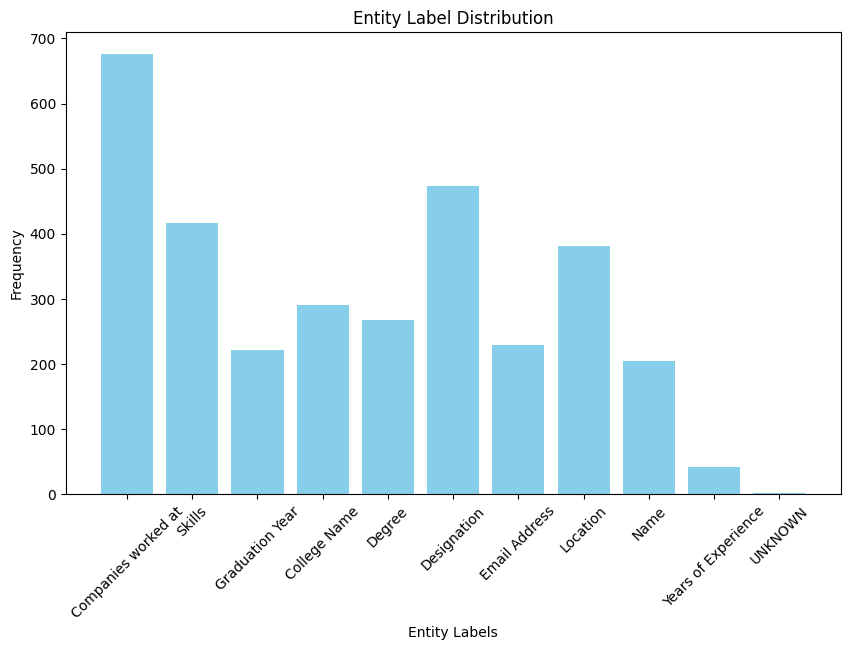

In [17]:
# Analyze entity distribution
entity_freq = Counter()
for record in df['annotation']:
    for annotation in record:
        labels = annotation['label']
        entity_freq.update(labels)

# Plot entity distribution
labels, counts = zip(*entity_freq.items())
plt.figure(figsize=(10, 6))
plt.bar(labels, counts, color='skyblue')
plt.xlabel('Entity Labels')
plt.ylabel('Frequency')
plt.title('Entity Label Distribution')
plt.xticks(rotation=45)
plt.show()

In [18]:
from scipy.stats import skew

# Calculate skewness
entity_counts = list(entity_freq.values())
entity_skewness = skew(entity_counts)

print("Entity Label Skewness:", entity_skewness)

Entity Label Skewness: 0.36540813195451866


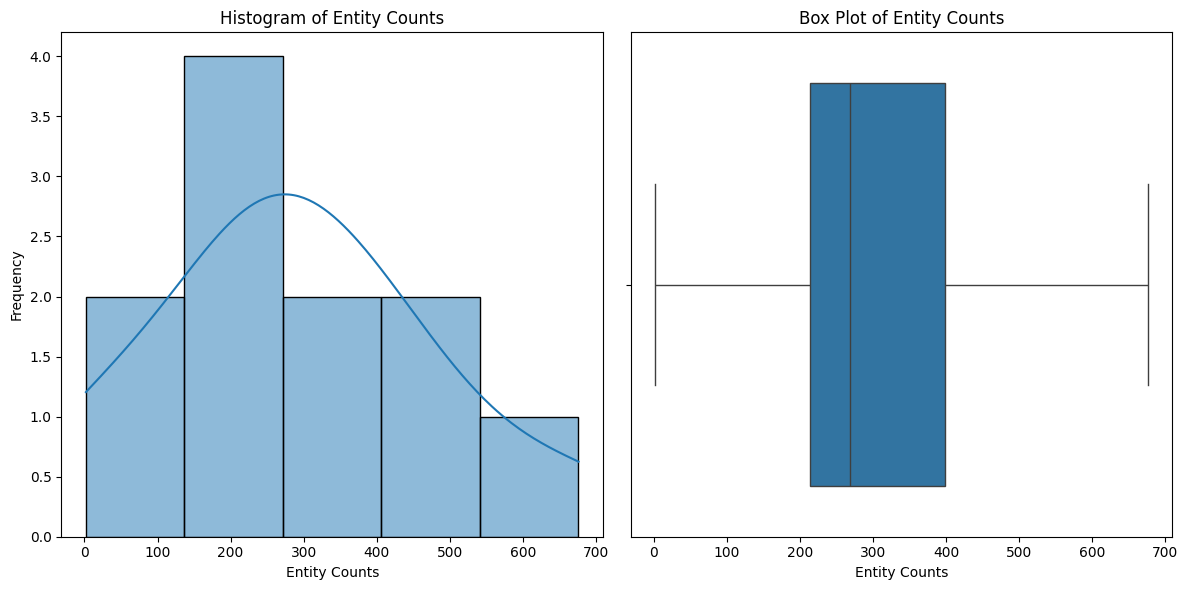

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the distribution with a histogram
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(entity_counts, kde=True)
plt.title('Histogram of Entity Counts')
plt.xlabel('Entity Counts')
plt.ylabel('Frequency')

# Visualize the distribution with a box plot
plt.subplot(1, 2, 2)
sns.boxplot(x=entity_counts)
plt.title('Box Plot of Entity Counts')
plt.xlabel('Entity Counts')

plt.tight_layout()
plt.show()


# Data Preprocessing

In [20]:
def get_annotation(annotaionList, label):
    ReqList = []
    for annotations in annotaionList:
        found = False
        for annot_dict in annotations:
            if annot_dict['label'] == [label]:
                ReqList.append(annot_dict['points'][0]["text"])
                found = True
                break
        if not found:
            ReqList.append(None)
    return ReqList

In [21]:
#Get all the content and annotation data as list
content = []
all_annotaions = []
for line in data:
    content.append(line["content"])
    all_annotaions.append(line["annotation"])

In [70]:
#List_of_email = get_annotation(all_annotaions,"Email Address")
List_of_Names = get_annotation(all_annotaions, "Name")
List_of_Skills = get_annotation(all_annotaions, "Skills")
List_of_companies_worked_at = get_annotation(all_annotaions, "Companies worked at")
List_Years_of_Experience = get_annotation(all_annotaions, "Years of Experience")
List_of_Designation = get_annotation(all_annotaions, "Designation")

In [23]:
def create_dataframe(title, data_list):
    # Remove None values and count frequencies
    data_list = [data for data in data_list if data is not None]
    counter = Counter(data_list)

    # Create DataFrame
    df = pd.DataFrame(counter.items(), columns=[title, 'Count'])
    return df



df_companies_worked_at = create_dataframe('Companies worked at', List_of_companies_worked_at)
df_skills = create_dataframe('Skills',List_of_Skills)

# Display the DataFrames
#print(df_location)

print(df_companies_worked_at)


                    Companies worked at  Count
0                                Oracle      8
1                       Oracle Retail\n      1
2                    Oracle Corporation      1
3    Oracle Financial Software Services      1
4                                 NIIT       1
..                                  ...    ...
102                  HCL Technologies\n      1
103                     PUNE UNIVERCITY      1
104                              Shell       1
105                     Infosys BPO Ltd      1
106            Infosys - Career Contour      1

[107 rows x 2 columns]


Remove newline characters

In [24]:
def remove_newlines_from_column(df, column_name):
    """
    This function removes newline characters from a specified column in a DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame containing the column to be cleaned.
        column_name (str): The name of the column from which to remove newline characters.

    Returns:
        pd.DataFrame: The DataFrame with the specified column's newline characters removed.
    """
    df[column_name] = df[column_name].str.replace('\n', ' ', regex=False)
    return df


In [25]:
import re

def remove_punctuation(text):
    pattern = r'[^\w\s]'
    return re.sub(pattern, '', text)

In [26]:
List_of_Degree = get_annotation(all_annotaions, "Degree")
df_degree = create_dataframe('Degree', List_of_Degree)

In [27]:
df_degree.sample(5)

,Degree,Count
64,M.Tech in Power Electronics and Instrumentatio...,1
30,C.B.S.E.\n,1
59,MBA in Finance and sectorial specialisation\n,1
19,Bachelors in Commerce (B.Com),1
99,BSc in Computer,1


In [28]:
df_degree = remove_newlines_from_column(df_degree, 'Degree')

In [29]:
df_degree.sample(5)

,Degree,Count
87,Bachelor of Computer Science in Computer Scien...,1
67,Bachelor of Technology in Civil Engineering,1
31,B.Tech,4
151,AMIE sec A,1
103,B-tech (CSE),1


In [30]:
df_degree.nunique()

Degree    158
Count       4
dtype: int64

In [31]:
# Get unique values
unique_degrees = df_degree['Degree'].unique()
unique_degrees.tolist()

['B.E in Computer Science Engineering',
 'B.Sc. in Computer Science',
 'B. Tech in Electrical and Electronics in Embedded Systems',
 'Bachelor of Technology in Computer Science',
 'CBSE in Mathematics and English ',
 'State Board',
 'B.com ',
 'B. Tech in Electronics and Communication ',
 'B E in Production Engineering',
 'PGDBM',
 'CBSE',
 'Bachelor of Engineering in Information Technology',
 'Bachelor of Engineering in Engineering',
 'B.Tech in CSE',
 'BE in computer science',
 'Board of Intermediate education',
 'Bachelor of computer science in computer science ',
 'B-Tech',
 'S.S.C in computer science',
 'Bachelors in Commerce (B.Com) ',
 'B.TECH. in Information Technology ',
 'B.E in Electronics & Communication ',
 'B.tech',
 'Bachelor of Computer Application',
 'H.S.C',
 'Master of Computer Application',
 'Bachelor in Electronics',
 'M.Tech. in IT',
 'e-commerce',
 'B.Tech ',
 'C.B.S.E. ',
 'B.Tech',
 'Computer Networking',
 'B.E. in ENC',
 'Bachelor Of Science',
 'B.S. in Electr

The data has be further cleaned to proces the data. This is done my mapping the qualifications according to the degree.

In [32]:
qualifications_map = {
        "b.e": "B.E",
        "be": "B.E",
        "b e":"B.E",
        "b.e.":"B.E",
        "bachelor of engineering":"B.E",
        "b.tech": "B.Tech",
        "b- tech":"B.Tech",
        "b. tech":"B.Tech",
        "b-tech":"B.Tech",
        "btech":"B.Tech",
        "b.c.a":"B.C.A",
        "mca":"M.C.A",
        "bachelor of technology":"B.Tech",
        "bsc":"B.Sc",
        "b.sc": "B.Sc.",
        "m.sc": "M.Sc.",
        "msc": "M.Sc.",
        "m.tech": "M.Tech",
        "mtech": "M.Tech",
        "diploma": "Diploma",
        "phd": "PhD",
        "doctorate": "Doctorate",
        "masters": "Masters",
        "bachelor": "Bachelor",
        "cbse":"Higher Secondary",
        "c.b.s.e":"Higher Secondary",
        "s.s.c":"Higher Secondary",
        "bachelor of engineering":"B.E",
        "pgdbm":"PGDBM",
        "m.tech.":"M.Tech",
        "bachelor of science":"B.Sc.",
        "dce":"DCE",
        "b.com":"B.COM",
        "mba":"MBA",
        "B. E":"B.E",
        "bcom":"B.Com",
        "b tech":"B.Tech",
        "achelor of Computer Application":"B.C.A",
        "Bachelor of Computer Application":"B.C.A",
        "B. Tech":"B.Tech",
        "b. e.":"B:E",
        "higher secondary":"Higher Secondary",
        "bbm":"BBM",
        "10th": "Seconday Education",
        "m.d":"M.D.",
        "b.b.a":"B.B.A",
        "btec hnc":"B.Tech",
        "state board": "Higher Secondary",
        "h.s.":"Higher Secondary",
        "master of computer application":"MCA",
        "ssc":"Senior Secondary"

    }


In [33]:
import re

def separate_degree(degree):
    """
    This function separates a degree string into qualification and domain.

    Args:
        degree (str): The degree string to be separated.

    Returns:
        tuple: A tuple containing (qualification, domain).
    """
    # Lowercase the degree for case-insensitive matching
    degree_lower = degree.lower()
   # print('@@ Degree @@:', degree)


    qualification = None
    for key in qualifications_map:
        if key in degree_lower:
            qualification = qualifications_map[key]
            break

    # Split the degree by keywords separating qualification and domain using regex
    if qualification:
        degree_lower = degree_lower.replace(qualification.lower(), "")  # Remove the qualification part
    split_words = re.split(r'\bin\b|\band\b', degree_lower)  # Split using 'in' and 'and' as delimiters

    # Identify domain based on remaining words
    domain_parts = []
    for word in split_words:
        #print('@@ Word in Split_words',word)
        if qualification and qualification.lower() not in word.strip():
            domain_parts.append(word.strip())

    domain = " ".join(domain_parts)

    # Handle cases where no qualification is found
    if qualification is None:
        qualification = "Not Applicable"

    return qualification, domain


# Assuming unique_degrees is a list containing degree strings
degrees = unique_degrees.tolist()
qualifications = []
domains = []

# Separate degrees and print the results
for degree in degrees:
    qualification, domain = separate_degree(degree)
    qualifications.append(qualification)
    domains.append(domain)
    #print(f"Degree: {degree}")
    #print(f"  Qualification: {qualification}")
    #print(f"  Domain: {domain}")
    #print("---")

# Create a DataFrame from the lists
df_degrees_processed = pd.DataFrame({
    "Degree": degrees,
    "Qualification": qualifications,
    "Domain": domains
})

# Display the DataFrame
#print(df_degrees_processed.head())


In [34]:
df_degrees_processed

,Degree,Qualification,Domain
0,B.E in Computer Science Engineering,B.E,computer science engineering
1,B.Sc. in Computer Science,B.Sc.,computer science
2,B. Tech in Electrical and Electronics in Embed...,B.E,b. tech electrical electronics embedded systems
3,Bachelor of Technology in Computer Science,B.Tech,bachelor of technology computer science
4,CBSE in Mathematics and English,Higher Secondary,cbse mathematics english
...,...,...,...
153,B.COM,B.COM,
154,'O' Level in Computer Application,Not Applicable,
155,BE in Environmental Engineering,B.E,be environmental engineering
156,B.Sc. in Biochemistry in Biochemistry,B.Sc.,biochemistry biochemistry


In [35]:
# to remove the lowercase degree from domain

q = list(qualifications_map.keys())
#print(q)
def filter_lowercase_qualifications(domain):
    domain_lower = domain.lower()
    for key in q:
        if key in domain_lower:
            print('Domain: ',domain_lower, ' Key present in domain: ', key)
            domain = domain.replace(key, "")
            #text = raw_text.replace("\n", ", ")
            print('After replace: ',domain )
    return domain

# Apply the function to 'Domain' column
df_degrees_processed['Domain'] = df_degrees_processed['Domain'].apply(filter_lowercase_qualifications)


Domain:  b. tech electrical electronics embedded systems  Key present in domain:  be
After replace:  b. tech electrical electronics emdded systems
Domain:  b. tech electrical electronics embedded systems  Key present in domain:  b. tech
After replace:   electrical electronics emdded systems
Domain:  bachelor of technology computer science  Key present in domain:  bachelor of technology
After replace:   computer science
Domain:  bachelor of technology computer science  Key present in domain:  bachelor
After replace:   computer science
Domain:  cbse mathematics english  Key present in domain:  cbse
After replace:   mathematics english
Domain:  state board  Key present in domain:  state board
After replace:  
Domain:  b. tech electronics communication  Key present in domain:  b. tech
After replace:   electronics communication
Domain:  b e production engineering  Key present in domain:  b e
After replace:   production engineering
Domain:  cbse  Key present in domain:  cbse
After replace:  

In [84]:
df_degrees_processed.sample(5)

,Degree,Qualification,Domain
91,Diploma in Mrac,Diploma,mrac
121,B.Sc. in Microbiology in Microbiology,B.Sc.,microbiology microbiology
14,BE in computer science,B.E,computer science
113,B.C.A,B.C.A,
88,Bachelor of Engineering in Electronics and Com...,B.E,electronics communication


# location Data

Data cleaning: Remove punctuations from locations

In [37]:
# Create DataFrames for each list
List_Locations = get_annotation(all_annotaions,"Location")
df_location = create_dataframe('Location', List_Locations)

In [38]:
df_location.isna().sum()

Location    0
Count       0
dtype: int64

In [39]:
def remove_punctuation(text):
    pattern = r'[^\w\s]'
    return re.sub(pattern, '', text)

# Assuming df_location is your DataFrame
df_location['Location'] = df_location['Location'].apply(remove_punctuation)

# Display the updated DataFrame
print(df_location)

             Location  Count
0           Bengaluru     34
1           Hyderabad     20
2       Irinchayam BO      1
3                Pune     16
4         Navi Mumbai      1
..                ...    ...
75           Amravati      1
76  Tiruchchirappalli      1
77      Muzaffarnagar      1
78              Dhule      1
79           Jamnagar      1

[80 rows x 2 columns]


In [40]:
df_location['Location'].apply(remove_punctuation)

0             Bengaluru
1             Hyderabad
2         Irinchayam BO
3                  Pune
4           Navi Mumbai
            ...        
75             Amravati
76    Tiruchchirappalli
77        Muzaffarnagar
78                Dhule
79             Jamnagar
Name: Location, Length: 80, dtype: object

In [41]:
df_location.sample(3)

,Location,Count
65,Tamil Nadu,1
22,Bangalore,8
35,Chennai,1


In [42]:
df_location = df_location.sort_values(by='Count', ascending=False)

In [43]:
location_mapping = {
    "bengaluru": "bangalore",
}

def replace_location(location):
    for key in location_mapping:
        if key in location:
            return location_mapping[key]
    return location


In [44]:
df_location['Location'] = df_location['Location'].str.lower()

# Apply the function to the 'Designation' column
df_location['Location']= df_location['Location'].apply(replace_location)

In [45]:
df_location = df_location.sort_values(by='Count', ascending=False)

In [46]:
df_location

,Location,Count
0,bangalore,34
1,hyderabad,20
3,pune,16
22,bangalore,8
5,chennai,7
...,...,...
67,kottayam,1
48,hyderabad,1
65,tamil nadu,1
64,qasba,1


# Skill Data

In this data we will not direclty remove the punctuations. The skills are seperated by comma or any other symols like dot or bullet points. So we have a seperate method to split the skills from the individual list of skills using regular expression. The skill data also contained words like ``Python (less than 1 year)``. This affects the skill data. So the number of years experience of a particular is removed.

In [47]:
# Create DataFrames for each list
List_of_Skills = get_annotation(all_annotaions,"Skills")

In [48]:
List_of_Skills = [skill for skill in List_of_Skills if skill != 'None']

In [49]:

df_skills = create_dataframe('skills', List_of_Skills)

In [50]:
df_skills.sample(5)

,skills,Count
18,"Tools: Manual Testing, Selenium (Selenium IDE,...",1
41,"\nLead genearation, Customer Handling, cold ca...",1
81,• Good Communication Skill\n• Sincere\n• Hard ...,1
85,"Azure (8 years), Asp.Net (8 years), C# (9 year...",1
128,"40 WPM (Less than 1 year), AUTOCAD (Less than ...",1


In [51]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [52]:
def clean_skill(skill):
    pattern = r'[•❖♦✓➢●:@]'
    # Use re.sub to replace the symbols with an empty string
    cleaned_skill = re.sub(pattern, '', skill).strip()
    return cleaned_skill

In [53]:
import re
import nltk
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

def extract_skills(raw_text):

    if raw_text is None:
        return []  # Return an empty list if raw_text is None

    # Step 1: Replace newlines with commas to handle multiline skills
    text = raw_text.replace("\n", ", ")

    # Step 2: Split the text by commas and semicolons
    skills_list = re.split(r'[;,•❖♦]', text)

    # Step 3: Strip leading and trailing whitespace from each skill
    skills_list = [skill.strip() for skill in skills_list]

    # Step 4: Filter out empty strings and 'None'
    skills_list = [skill for skill in skills_list if skill and skill != 'None']

    # Step 5: Remove stop words from skills (you can replace stop_words with your list)
    stop_words = set(stopwords.words('english'))
    skills_list = [skill for skill in skills_list if skill.lower() not in stop_words]

    # Step 6: Filter out skills containing only single digits or the word 'years'
    filtered_skills = []
    for skill in skills_list:

        # Check if the skill contains only a single digit or 'years'
        if not (skill.isdigit() and len(skill) == 1) and skill.lower() != 'years':
          # Check for patterns like "(Less than 1 year)" or "(2 years)"
             if not re.match(r'^\s*(?:Less than)?\s*\d+\s*(?:year|years)?\s*$', skill, re.IGNORECASE):
                # Remove duration information like "(8 years)", "(9 years)", etc.
                skill = re.sub(r'\(\s*(?:Less than)?\s*\d+\s*(?:year|years)?\s*\)', '', skill).strip()
                skill = re.sub(r'\d+\s*\+\s*(?:year|years)?', '', skill).strip()
                filtered_skills.append(skill)


    # Step 7: Remove symbols like •, ❖, ♦ from each skill
    cleaned_skills = []
    for skill in filtered_skills:
        cleaned_skill = clean_skill(skill)
        cleaned_skills.append(cleaned_skill.strip())

    return cleaned_skills


# Extract and print skills from the first item in the list
extracted_skills_list = [extract_skills(raw_skill) for raw_skill in List_of_Skills]

# Print the extracted skills for each item in the list
for i, skills in enumerate(extracted_skills_list):
    print(f"Extracted skills for item {i+1}: {skills}")

Extracted skills for item 1: ['Languages Core Java', 'Go Lang', 'Data Structures & Algorithms', 'Oracle', 'PL-SQL programming', 'Sales Force with APEX.', 'Tools RADTool', 'Jdeveloper', 'NetBeans', 'Eclipse', 'SQL developer', 'PL/SQL Developer', 'WinSCP', 'Putty', 'Web Technologies JavaScript', 'XML', 'HTML', 'Webservice', 'Operating Systems Linux', 'Windows', 'Version control system SVN & Git-Hub', 'Databases Oracle', 'Middleware Web logic', 'OC4J', 'Product FLEXCUBE Oracle FLEXCUBE Versions 10.x', '11.x and 12.x']
Extracted skills for item 2: ['Functional Testing', 'Blue Prism', 'Qtp']
Extracted skills for item 3: ['Languages & Technologies Python', 'R', 'SQL', 'NoSQL', 'Predictive Modelling', 'Market Basket Analysis', 'Sentimental Analysis', 'Clustering', 'Bash', 'Scripting (Preliminary)', 'Socket Programming', 'Java (Preliminary)', 'Tools R Studio', 'Jupyter', 'GIT', 'Sublime', 'MATLAB', 'Linux', 'KVM', 'Virtual Box', 'Open VZ', 'Oracle SQL Developer', 'MySQL', 'MongoDB', 'Excel']
E

In [54]:
import pandas as pd
from collections import Counter
import re

# Remove empty skills
cleaned_skills_list = [[skill for skill in skills if skill] for skills in extracted_skills_list]

# Flatten the list
flattened_skills_list = [skill for skills in cleaned_skills_list for skill in skills]

cleaned_skills = [clean_skill(skill) for skill in flattened_skills_list]

In [55]:
cleaned_skills

['Languages Core Java',
 'Go Lang',
 'Data Structures & Algorithms',
 'Oracle',
 'PL-SQL programming',
 'Sales Force with APEX.',
 'Tools RADTool',
 'Jdeveloper',
 'NetBeans',
 'Eclipse',
 'SQL developer',
 'PL/SQL Developer',
 'WinSCP',
 'Putty',
 'Web Technologies JavaScript',
 'XML',
 'HTML',
 'Webservice',
 'Operating Systems Linux',
 'Windows',
 'Version control system SVN & Git-Hub',
 'Databases Oracle',
 'Middleware Web logic',
 'OC4J',
 'Product FLEXCUBE Oracle FLEXCUBE Versions 10.x',
 '11.x and 12.x',
 'Functional Testing',
 'Blue Prism',
 'Qtp',
 'Languages & Technologies Python',
 'R',
 'SQL',
 'NoSQL',
 'Predictive Modelling',
 'Market Basket Analysis',
 'Sentimental Analysis',
 'Clustering',
 'Bash',
 'Scripting (Preliminary)',
 'Socket Programming',
 'Java (Preliminary)',
 'Tools R Studio',
 'Jupyter',
 'GIT',
 'Sublime',
 'MATLAB',
 'Linux',
 'KVM',
 'Virtual Box',
 'Open VZ',
 'Oracle SQL Developer',
 'MySQL',
 'MongoDB',
 'Excel',
 'Languages Core Java',
 'Front end/G

In [56]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [57]:
df_s = pd.DataFrame(cleaned_skills, columns=['skill'])
df_s['skill'] = df_s['skill'].str.lower()


In [58]:
import pandas as pd

# Example custom stop words
custom_stopwords = {'having', 'experience', 'hands-on', 'knowledge', 'of', 'on', 'with', 'working', 'undergone', 'training', 'about','worked','at','and','to','key skills:',
                    'ability','languages','tools','rogramming','programming','less','than','years','year'}

# Define the remove_custom_stopwords function
def remove_custom_stopwords(text, custom_stopwords):
    # Split text by spaces
    words = re.split(r'\s+', text)

    # Remove custom stop words from each word
    filtered_words = [word for word in words if word.lower() not in custom_stopwords]

    # Join the filtered words back into a single string
    filtered_text = ' '.join(filtered_words)

    return filtered_text



In [59]:
# Apply the function to the 'skill' column in DataFrame
df_s['filtered_skill'] = df_s['skill'].apply(lambda x: remove_custom_stopwords(x, custom_stopwords))

# Print the updated DataFrame
df_s

,skill,filtered_skill
0,languages core java,core java
1,go lang,go lang
2,data structures & algorithms,data structures & algorithms
3,oracle,oracle
4,pl-sql programming,pl-sql
...,...,...
1952,splunk,splunk
1953,network security,network security
1954,arc sight,arc sight
1955,siem,siem


In [60]:
skills_df = df_s[df_s['filtered_skill'] != 'additional information']

In [61]:

skills_df.head(10)

,skill,filtered_skill
0,languages core java,core java
1,go lang,go lang
2,data structures & algorithms,data structures & algorithms
3,oracle,oracle
4,pl-sql programming,pl-sql
5,sales force with apex.,sales force apex.
6,tools radtool,radtool
7,jdeveloper,jdeveloper
8,netbeans,netbeans
9,eclipse,eclipse


# Desgination

**Data Cleaning**

remove unncessary white spaces and newline characters from the text

In [62]:
# Create a DataFrame from the list with a column named 'Designation'
df_designation = pd.DataFrame(List_of_Designation, columns=['Designation'])

# Remove newline characters and leading/trailing white spaces
df_designation['Designation'] = df_designation['Designation'].str.replace('\n', '').str.strip()





In [63]:
df_nan_designations = df_designation[df_designation['Designation'].isna()]

In [64]:
df_nan_designations

,Designation
5,None
37,None
49,None
53,None
74,None
84,None
87,None
115,None
119,None
136,None


In [65]:
df_designation.dropna(subset=['Designation'], inplace=True)

In [66]:
# Group by 'Designation' and count occurrences
df_designation_grouped = df_designation.groupby('Designation').size().reset_index(name='Count')

# Sort the grouped DataFrame by count in descending order
df_designation_grouped_sorted = df_designation_grouped.sort_values(by='Count', ascending=False)

In [67]:
pd.set_option('display.max_rows', None)
print(df_designation_grouped_sorted)

                                           Designation  Count
110                                  Software Engineer      5
8                                 Associate Consultant      4
123                                    System Engineer      3
124                                   Systems Engineer      3
30                                           Developer      3
132                         Technical Support Engineer      3
140                                      Test Engineer      3
78                                        Project Lead      2
95                            Senior Process Executive      2
113                                 Software developer      2
130                                     Technical Lead      2
27                                 Data Entry Operator      2
101                            Senior Systems Engineer      2
136                                 Technology Analyst      2
21                                          Consultant      2
99      

# Futher processing

**Data Mapping**

There are certain designations which are same, like ``'Sytems Engineer'`` and ``'System Engineer'``. So we have to map these designations.

In [68]:
df_designation['Designation'].isna

<bound method Series.isna of 0                                   Associate Consultant
1                                             QA Analyst
2                                    Data Analyst Intern
3                                   Associate Consultant
4                                  Application Developer
6                      FI/CO Consultant in Tech Mahindra
7                                   Associate consultant
8                                       Systems Engineer
9                                       Sr Test Engineer
10                                      Systems Engineer
11                                           Team Member
12                                Senior System Engineer
13                                 Network Ops Associate
14                                             Developer
15                            Technical Support Engineer
16                                  DEVOPS ADMINISTRATOR
17          Certified Network Associate Training Program
18                               Senior Systems Engineer
19                                Software Test Engineer
20                              Senior software engineer
21              Senior Analyst -Supplier Data Management
22                          Software Automation Engineer
23                               Senior Software Analyst
24                                 IT Operations Analyst
25                               Server Support Engineer
26                                         Test Engineer
27                                           fresher job
28                                            Consultant
29                                         Test Engineer
30                                       System Engineer
31                                 PeopleSoft consultant
32                                      SYSTEMS ENGINEER
33                                Senior System Engineer
34                                Configuration Engineer
35                                  Principal Consultant
36     Officer-HR & Administration in H.& R. Johnson ...
38                           Associate Software Engineer
39                                     Process Associate
40                                  Associate Consultant
41                                          Project Lead
42                              CES ASSOCIATE CONSULTANT
43                                     Software Engineer
44                       Functional Consultant / WM Lead
45                        Working as Escalation Engineer
46                            Technical Support Engineer
47                JAVA Developer/Senior Systems Engineer
48                                 Application Developer
50                                     Software Engineer
51                             Technology Lead / Analyst
52                                           App develop
54                               Senior Systems Engineer
55                            Associate network engineer
56                                        Technical Lead
57                                      Quality Engineer
58                                            Consultant
59                              Specialist II, Marketing
60                                 Online Content Writer
61                                  Technical Consultant
62                                       System Engineer
63                                    Technology Analyst
64                                   L1 network engineer
65                            Technical support engineer
66                            Technical Support Engineer
67                                       Finance Analyst
68                                     software engineer
69                                      Sr. Test Manager
70                                  Associate Consultant
71                    Principal Engineer Technical Staff
72                                 FI Support Consultant
73                                    

In [69]:
designation_mapping = {
    "developer": "software developer",
    "systems engineer": "system engineer",
    "senior systems engineer": "senior system engineer",
    "software":"software developer",
    "qa analyst":"quality analyst"
}

def replace_designation(designation):
    for key in designation_mapping:
        if key in designation:
            return designation_mapping[key]
    return designation

df_designation['Designation'] = df_designation['Designation'].str.replace('\n', '').str.strip()
df_designation['Designation'] = df_designation['Designation'].str.lower()

# Apply the function to the 'Designation' column
df_designation['Designation'] = df_designation['Designation'].apply(replace_designation)



#included the mapping here
df_designation['Designation'] = df_designation['Designation'].replace(designation_mapping)


,Designation,Count
98,software developer,28
108,system engineer,10
8,associate consultant,5
116,technical support engineer,4
122,test engineer,3
74,project lead,2
23,data entry operator,2
113,technical consultant,2
114,technical lead,2
87,senior process executive,2


In [71]:
# Create a DataFrame from the list with a column named 'Designation'
df_names = pd.DataFrame(List_of_Names, columns=['Names'])


,Names
0,Govardhana K
1,Harini Komaravelli
2,Hartej Kathuria
3,Ijas Nizamuddin
4,Imgeeyaul Ansari
5,Jay Madhavi
6,Jitendra Babu
7,Jyotirbindu Patnaik
8,Karthihayini C
9,Karthik GV


In [72]:
df_names.isna().sum()

Names    1
dtype: int64

In [73]:
df_names.dropna(subset=['Names'], inplace=True)

In [74]:
df_names.sample(5)

,Names
117,Dushyant Bhatt
133,Laya A
181,Akash Gulhane
110,Chhaya Prabhale
90,Sameer Kujur
